Class that linearize and discretize a model arounf a point

In [ ]:
#import library
from sympy import symbols, IndexedBase, Idx
import sympy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#from scipy.misc import derivative
from sympy import *

class DiscretizeandLinearizeGeneric():
  def __init__(self,Z,xhat,uhat,n):
    #matrix A of states linearize 
        self.Aj = np.zeros(shape= (x[n_states].shape[0],x[n_states].shape[0]))     
        #matrix B of input linearize
        self.Bj = np.zeros(shape= (x[n_states].shape[0],u[n_in].shape[0]))
        #point around that we will make the linearization 
        self.xhat = xhat[:]
        self.uhat = uhat[:]
        #equation of states (ODE)
        self.Z = Z
        #matrix of the difference between the real equation and the linearize one
        self.p = []
        #matrix of the discretize system
        self.Ad=[]
        self.Bd=[]
        self.Cd=[]
        #list of matrix discrete to make the convex opt
        self.Ad_list = [None]*(n-1)
        self.Bd_list = [None]*(n-1)
        self.Cd_list = [None]*(n-1)

  def evaluatePerte(self):
      dxdt = self.Z[:]
      #linearize the A matrix with symbols
      xhat = self.xhat
      uhat = self.uhat
      #evaluate the real system around the point xhat,uhat
      for c in range(len(dxdt)):
        for i in range(len(xhat)):
            dxdt[c] = dxdt[c].subs(x[i],xhat[i])
        for i in range(len(uhat)):
            dxdt[c]= dxdt[c].subs(u[i],uhat[i])
      #save the result inside a matrix
      #p will be the waste of the linearize system
      self.p = -self.p + dxdt[:]

      #class that calculate the matrix A and B jacobien and make the evaluation around the points xhat and uhat 
  def JacobianAndEvaluate(self):
      dxdt = self.Z[:]
      #linearize the A matrix with symbols
      xhat = self.xhat
      uhat = self.uhat
      #linearize the A matrix with symbols
      for c in range (len(dxdt)):
        for h in range (x[n_states].shape[0]):
          #calculate the derivative of the c ode of the x[h] variable of states
          A = sp.diff(dxdt[c],x[h])
          for i in range(len(xhat)):
            A = A.subs(x[i],xhat[i])
          for i in range(len(uhat)):
            A = A.subs(u[i],uhat[i])
          self.Aj[c][h] = A
      #self.Aj = np.array([[sp.diff(dx1dt,x[0]),sp.diff(dx1dt,x[1]),sp.diff(dx1dt,x[2])],[sp.diff(dx2dt,x[0]),sp.diff(dx2dt,x[1]),sp.diff(dx2dt,x[2])],[sp.diff(dx3dt,x[0]),sp.diff(dx3dt,x[1]),sp.diff(dx3dt,x[2])]])
      #linearize B matrix with symbols
      for c in range (len(dxdt)):
        for h in range (u[n_in].shape[0]):
          #calculate the B matrix making the derivative of ode respect to the inputs
          B = sp.diff(dxdt[c],u[h])
          for i in range(len(xhat)):
            B = B.subs(x[i],xhat[i])
          for i in range(len(uhat)):
            B = B.subs(u[i],uhat[i])
          self.Bj[c][h] = B
      #self.Bj = np.array([[sp.diff(dx1dt,u[0]),sp.diff(dx1dt,u[1])],[sp.diff(dx2dt,u[0]),sp.diff(dx2dt,u[1])],[sp.diff(dx3dt,u[0]),sp.diff(dx3dt,u[1])]])
      #print(self.Bj)
      #pass the information of the evaluation of the equation to evaluate the waste between the linear and non linear system
      self.p = np.dot(self.Bj,uhat) + np.dot(self.Aj,xhat)
      self.evaluatePerte()

  def mod_point(self,xhat,uhat):
    #calculate the matrix of the system to make the discretization 
        self.xhat = xhat[:]
        self.uhat = uhat[:]
        self.JacobianAndEvaluate()
  
  def lin2disc(self,xhat,uhat,n,dt):
        #discretize the system 
        self.mod_point(xhat,uhat)
        resolution = 100
        Adx_list = [None] * (resolution+1)
        Adr_list = [None] * (resolution+1)
        Adx_list[0] = np.eye(x[n_states].shape[0])
        Adr_list[0] = np.eye(x[n_states].shape[0])
        delta=dt/resolution
        for i in range(resolution):
          Adx_list[i+1] = Adx_list[i] + np.dot(Adx_list[i],self.Aj)*delta
          Adr_list[i+1] = Adr_list[i] - np.dot(Adr_list[i],self.Aj)*delta
        self.Ad = Adx_list[resolution]
        self.Bd = np.zeros([x[n_states].shape[0],u[n_in].shape[0]])
        self.Cd = np.zeros([x[n_states].shape[0],])
        #self.p = np.reshape(self.p,(3,1))
        #print(self.p)
        for i in range(resolution):
          Ard = Adr_list[i+1]
          self.Bd = self.Bd + (np.dot(Ard,self.Bj)*delta)
          self.Cd = self.Cd + (np.dot(Ard,self.p)*delta)
        self.Bd = np.dot(self.Ad,self.Bd)
        self.Cd = np.dot(self.Ad,self.Cd)
        #print(self.Ad)
        #print(self.Bd)
        #print(self.Cd)
        return self.Ad,self.Bd,self.Cd


  def disc(self,uw,n,dt,x_ss):
    #evaluate the system discrete 
      tf = dt*n 
      t = np.linspace(0,tf,n)
        # store solution
      xk = np.zeros(shape =(x[n_states].shape[0],n))
      # record initial conditions
      xk[:,0] = x_ss
      for i in range(1,n):
          u0 = uw[:,i-1]
          x0 = xk[:,i-1]
          #calculate the discrete matrix around the points x0 and u0
          self.Ad_list[i-1],self.Bd_list[i-1],self.Cd_list[i-1] = self.lin2disc(x0,u0,n,dt)
          #store solutions
          xk[:,i] = np.dot(self.Ad,x0)+np.dot(self.Bd,u0) + self.Cd 
      return xk 
      
  def get_list(self):
    return np.array(self.Ad_list).astype(np.float64),np.array(self.Bd_list).astype(np.float64),np.array(self.Cd_list).astype(np.float64)



Class that provide the calculation of CVX method to generate a trajectory


TRY TO create an obstacle to be avoided at 0.5 , 0.5 but not working with linear or quadratic constrains

In [ ]:
# Import packages.
import cvxpy as cp
import numpy as np

class ConvexOpt():
  def __init__(self,N,x_init,x_fin,u_in,A_list,B_list,C_list,xante,uante,p):
    #init the variables of the class
    self.N = N
    self.x_init = x_init
    self.x_fin = x_fin
    self.u_in = u_in
    self.Ad_list = A_list
    self.Bd_list = B_list
    self.Cd_list = C_list
    self.xante = xante
    self.uante = uante
    self.p = p
    
  def CVXOPT(self,opt_power = False,opt_velocity = False):
    #save the number of states and inputs
    x_len =(int) (x[n_states].shape[0])
    u_len = (int) (u[n_in].shape[0])
    #define the variables to be evaluate 
    xv = cp.Variable(shape=(x_len, self.N))
    uv = cp.Variable((u_len, self.N-1))
    tau = cp.Variable(shape=(self.N))
    tau_vel = cp.Variable(shape=(self.N))
    tau_u = cp.Variable(shape=(self.N-1))
    hogb = cp.Variable(self.N-1)
    hog = cp.Variable(shape = (x_len,self.N-1))
    nu = cp.Variable(1,)
    #define the objective of the convex optimization 
    obj = cp.sum_squares(np.ones(shape=(1,self.N))*tau +np.ones(shape=(1,self.N))*tau_vel + 10*np.ones(shape=(1,self.N-1))*tau_u  + np.ones(shape=(1,self.N-1))*10**3*hogb+ 10**7*nu)
    obj = cp.Minimize(obj)
    #define all constrains to be take into account but they have to be convex 
    constr = []
    #initial condition for x-y position and angular position
    constr += [xv[:,0] == self.x_init]
    #initial condition related to inputs 
    constr += [uv[:,0] == self.u_in]
    #final position constrain 
    constr += [cp.norm(xv[:,self.N-1] - self.x_fin) <= 10e-9]
    #trajectory limitation 
    for t in range(0,self.N-1):
      #discrete trajectory with virtual control 
        constr += [ xv[:,t+1] == self.Ad_list[t]@xv[:,t] + self.Bd_list[t] @ uv[:,t] + self.Cd_list[t]]
        #norm(hog(:,k)) <= hogb(k)
        constr += [cp.norm(hog[:,t]) <= hogb[t]]

    #take into account only the shortest trajectory 
        #constr += [cp.norm(xv[:,t-1] - xv[:,t]) <= tau[t]]

        #I tried to code linear obstacle but  working only in rectangular case  
        #constr += [xv[1,t] <= 6]
        #constr += [xv[1,t] >= 0]
        #constr += [xv[0,t] <= 5] 
        #constr += [cp.norm2(xv[0,t] - 1) >= 1]

        #contrainte qui definit la presence d'un obstacle
        #position
        H = np.array([[1,0],[0,1]], dtype=float) #geometrie
        if np.any(self.xante) and np.any(self.uante): #contrainte qui vient de la thèse de Miki
            A = H
            b = np.dot(H,self.p)
            v = np.dot(H,self.xante[:2,t]) - b
            f = cp.norm2(v)
            constr += [nu >= 0]
            constr += [f+np.transpose(A@v)@(xv[:2,t]-self.xante[:2,t])/f >= 1 - nu]
            constr += [cp.norm(self.xante[:,t]-xv[:,t]) <= tau[t]]  #contrainte de distance entre deux points de deux iterations successives
    #limit the final velocity    
    constr += [cp.norm(uv[:,self.N-2]) <= 10e-9]
    #contrain of the velocity of convergence to the final point % ||target - x_k||_2 <= taui_k
    if(opt_velocity):
      for t in range (0,self.N-1):
        constr += [cp.norm2(xv[:,t] - self.x_fin)<= tau_vel[t]]
    #constrain to optimize the power efficency related to the norm of u
    if(opt_power):
      for t in range (0,self.N-2):
        constr += [cp.norm(uv[:,t]) <= tau_u[t]]

    #resolve the problem    
    prob = cp.Problem(obj , constr)
    prob.solve(solver = cp.SCS,verbose=True)
    xv = np.array(xv.value)
    uv = np.array(uv.value)
    return xv,uv

LEt' s combine the two classes

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 354
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 158, constraints m = 183
Cones:	primal zero / dual free vars: 35
	linear vars: 31
	soc vars: 117, soc blks: 32
Setup time: 6.31e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.75e+03  1.98e+02  1.00e+00 -2.49e+05  2.50e+04  7.22e-11  9.14e-03 
   100| 1.66e+00  3.04e+00  5.84e-02  2.35e+02  2.64e+02  7.10e-12  1.30e-02 
   200| 3.87e+01  4.00e+01  4.80e-01  5.49e+03  1.56e+04  1.26e-

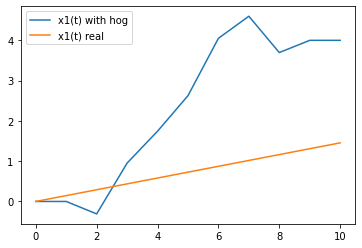

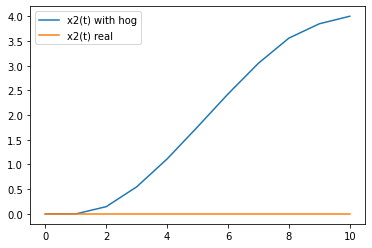

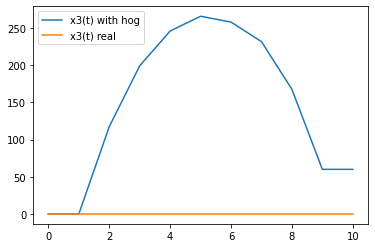

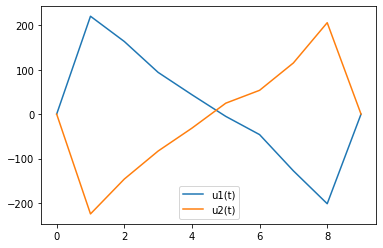

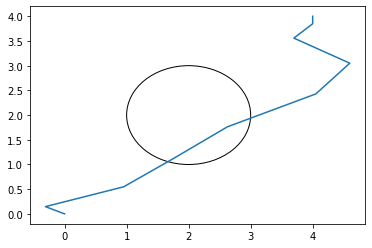

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.32e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.32e+22  1.66e+22  1.00e+00 -1.88e+25  1.07e+25  2.45e+24  4.44e-03 
   100| 5.37e-02  1.08e+00  9.89e-01 -2.33e+01  6.97e+01  4.59e-12  1.05e-02 
   200| 1.04e-02  4.00e-01  9.75e-01 -4.49e+00  3.47e+01  2.29e-

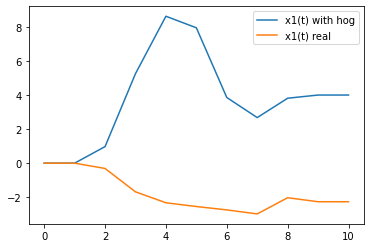

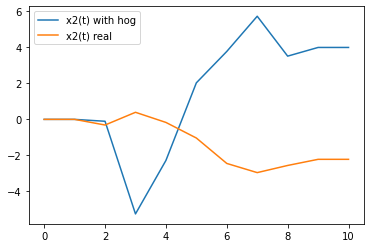

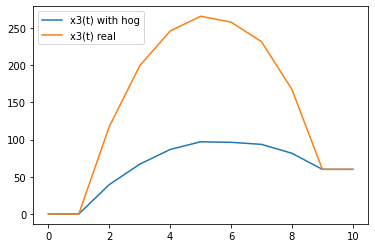

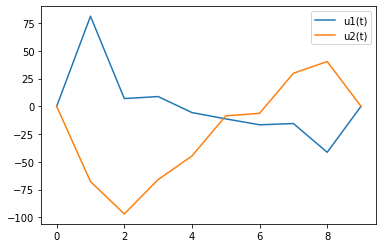

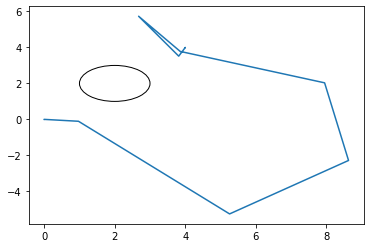

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 7.08e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.92e+03  4.20e+02  1.00e+00 -4.13e+05  7.58e+04  1.14e-10  7.85e-03 
   100| 7.06e-02  1.49e+01  9.89e-01  1.51e+01 -7.25e+01  8.91e-12  1.28e-02 
   200| 1.47e-02  6.77e-01  8.39e-01 -3.12e+00 -4.08e+01  1.28e-

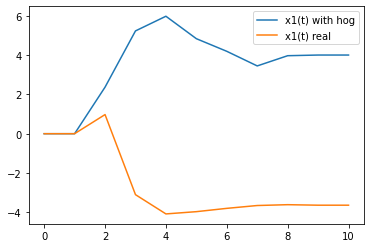

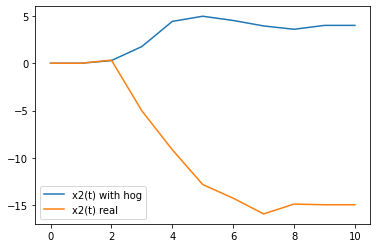

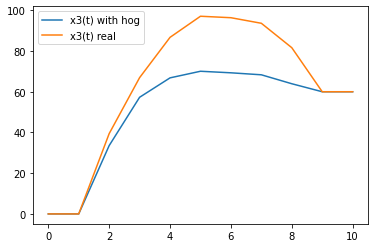

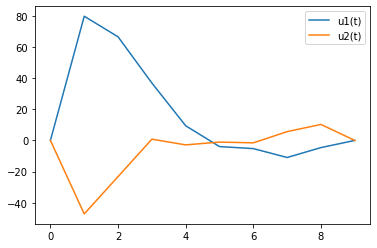

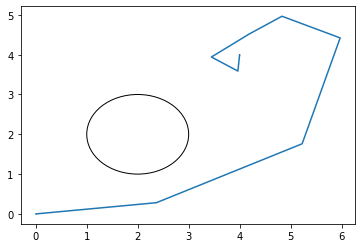

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 3.18e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.76e+03  3.59e+02  1.00e+00 -3.34e+05  5.26e+04  9.11e-11  8.25e-03 
   100| 7.08e-03  1.15e+01  9.67e-01  1.02e+00  9.00e+01  1.55e-11  1.33e-02 
   200| 5.58e-02  2.21e+00  9.79e-01 -1.06e+01  3.54e+01  6.26e-

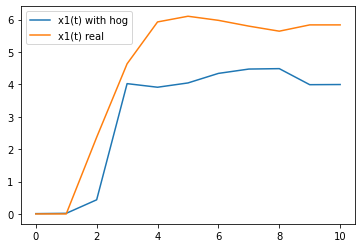

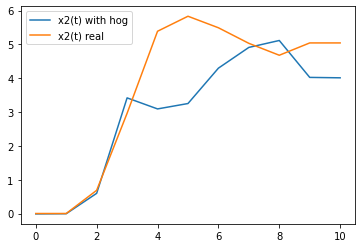

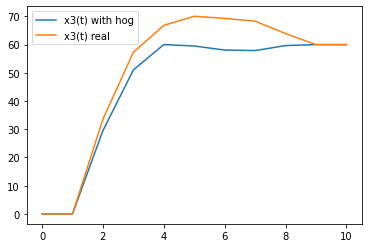

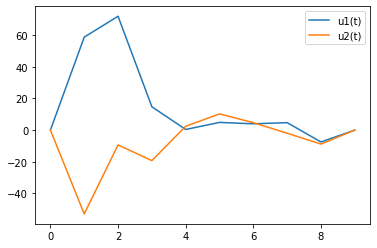

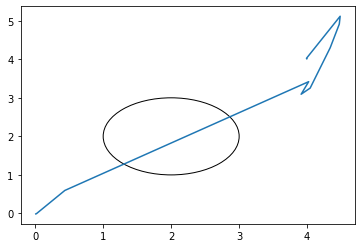

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.27e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.86e+03  3.95e+02  1.00e+00 -3.37e+05  5.72e+04  9.23e-11  7.97e-03 
   100| 1.10e-01  8.69e+00  5.06e-01  1.98e+01  6.15e+01  9.42e-12  1.27e-02 
   200| 1.00e-01  5.51e+00  3.05e-01  1.81e+01  3.43e+01  1.53e-

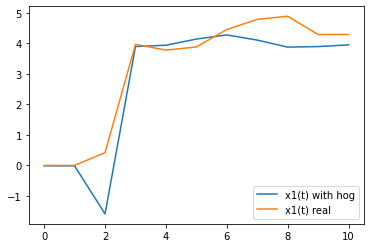

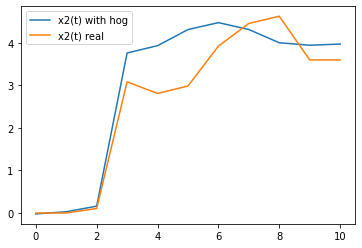

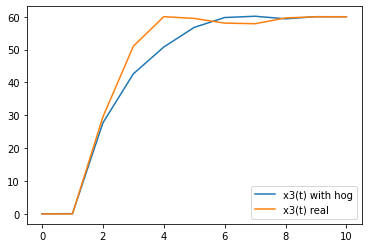

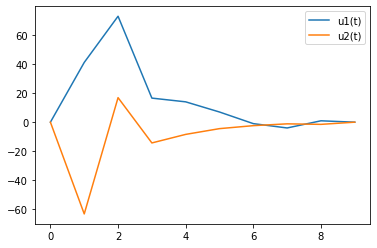

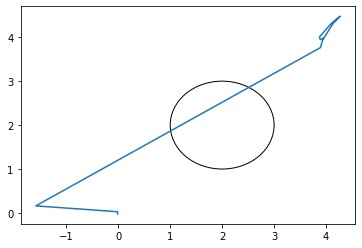

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 4.57e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.96e+03  4.30e+02  1.00e+00 -3.49e+05  6.28e+04  9.60e-11  8.99e-03 
   100| 2.34e-02  1.63e+01  8.65e-01  3.99e+00  6.15e+01  1.96e-13  1.40e-02 
   200| 2.25e-02  2.30e+00  9.90e-01  3.84e+00 -9.26e+01  4.74e-

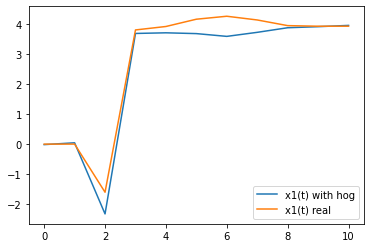

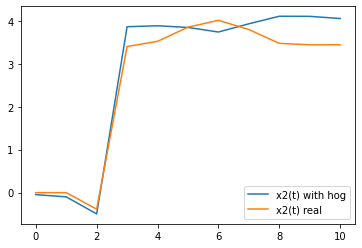

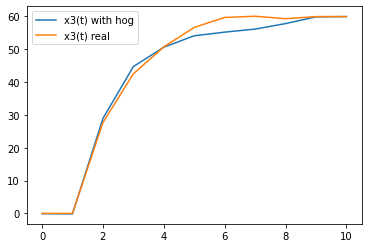

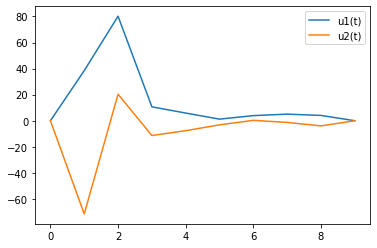

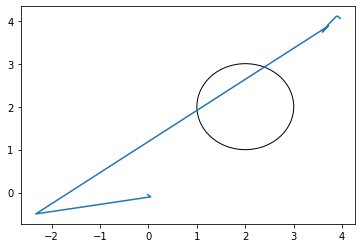

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 3.29e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.98e+03  4.34e+02  1.00e+00 -3.48e+05  6.39e+04  9.61e-11  7.95e-03 
   100| 5.63e-01  3.29e+01  9.96e-01  9.94e+01 -1.76e+02  4.59e-13  1.26e-02 
   200| 4.73e-01  1.45e+01  9.98e-01  8.33e+01 -3.59e+02  5.10e-

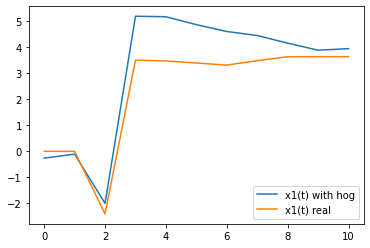

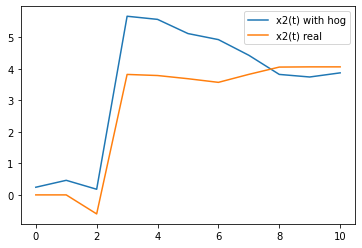

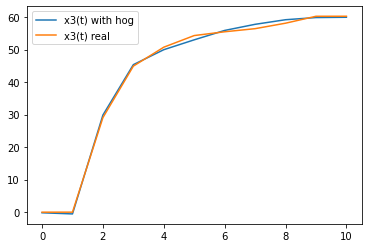

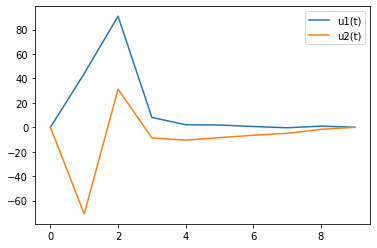

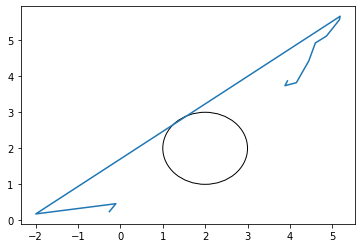

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 3.05e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.95e+03  4.44e+02  1.00e+00 -3.46e+05  6.33e+04  9.54e-11  1.56e-02 
   100| 2.78e-01  2.87e+00  9.89e-01  4.93e+01 -3.69e+01  6.19e-12  2.07e-02 
   200| 6.35e-02  4.83e+00  8.44e-01  1.11e+01  1.37e+02  3.57e-

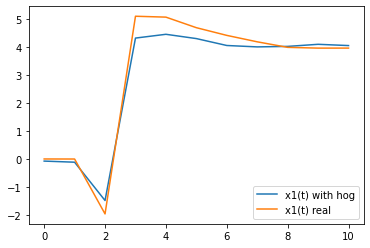

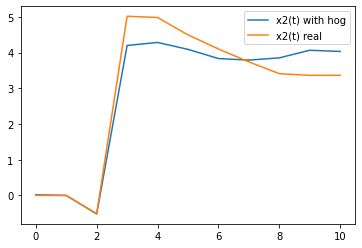

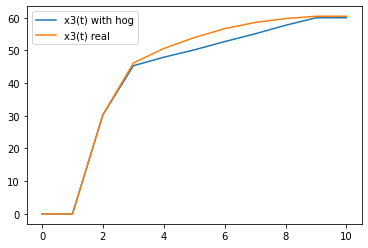

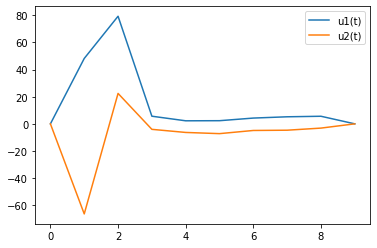

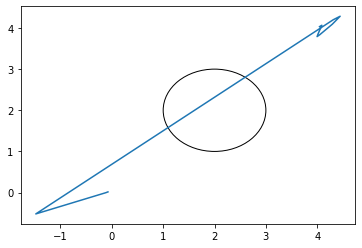

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.15e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.01e+03  4.50e+02  1.00e+00 -3.52e+05  6.57e+04  9.71e-11  5.33e-03 
   100| 2.55e-01  1.06e+01  4.44e-01  4.46e+01  1.17e+02  5.85e-12  1.12e-02 
   200| 4.45e-01  1.24e+01  9.89e-01  7.79e+01 -1.56e+01  3.74e-

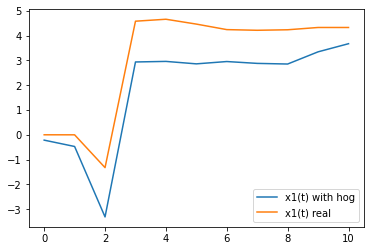

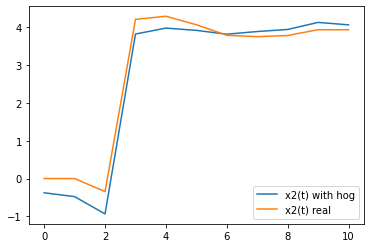

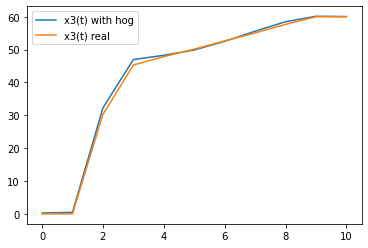

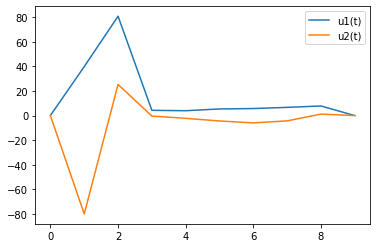

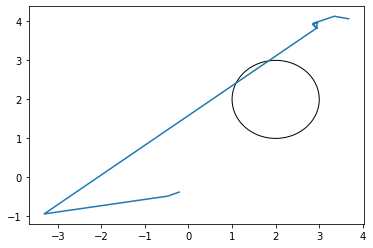

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 5.98e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.89e+03  4.04e+02  1.00e+00 -3.31e+05  6.04e+04  9.20e-11  4.85e-03 
   100| 1.47e-01  1.20e+01  7.58e-01  2.57e+01  1.90e+02  1.14e-12  1.06e-02 
   200| 1.54e-01  7.87e+00  7.94e-01  2.69e+01  2.39e+02  5.34e-

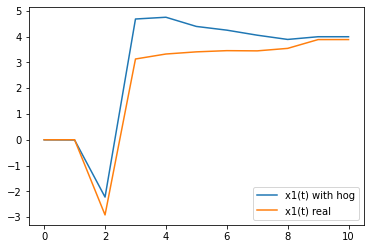

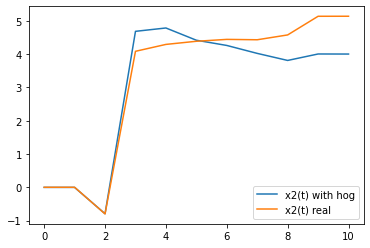

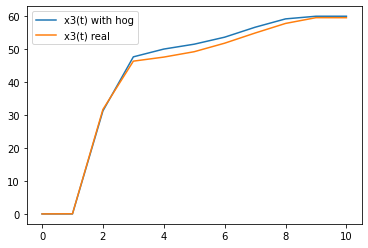

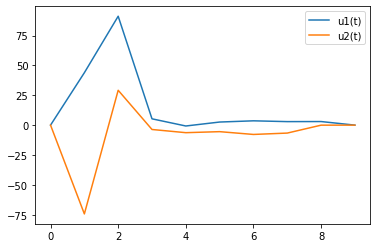

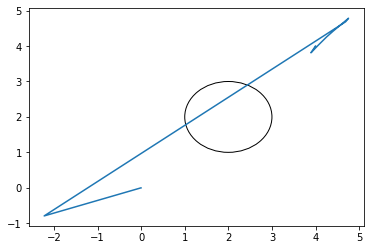

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 3.37e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.98e+03  4.40e+02  1.00e+00 -3.49e+05  6.31e+04  9.60e-11  1.28e-02 
   100| 1.02e-01  3.83e+00  8.15e-01 -1.80e+01 -1.81e+02  5.94e-12  1.75e-02 
   200| 2.45e-01  5.12e+00  5.23e-01  4.32e+01  1.39e+02  6.15e-

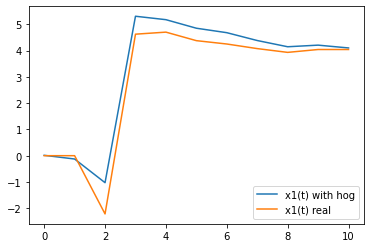

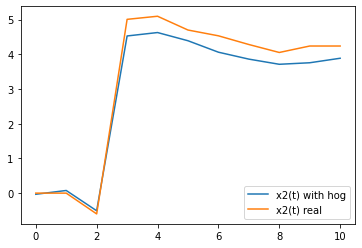

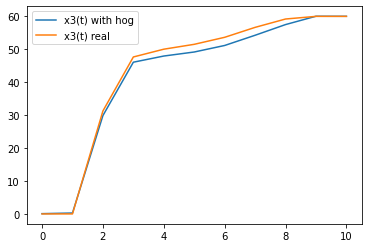

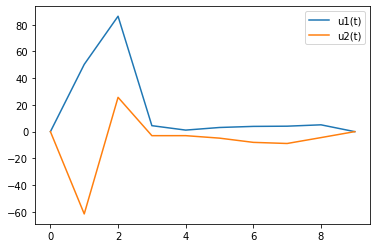

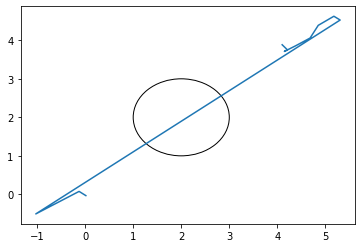

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 7.84e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.99e+03  4.50e+02  1.00e+00 -3.48e+05  6.55e+04  9.63e-11  6.65e-03 
   100| 2.98e-01  4.82e+00  4.16e-01  5.21e+01  1.27e+02  8.19e-12  1.18e-02 
   200| 4.07e-01  1.05e+01  9.92e-01  7.11e+01 -6.08e+01  4.92e-

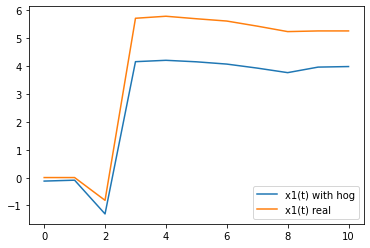

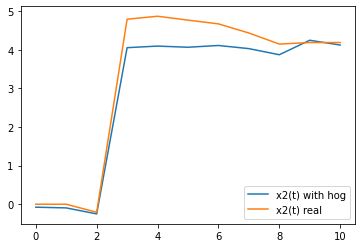

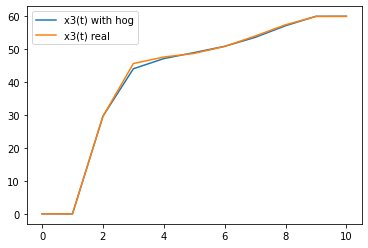

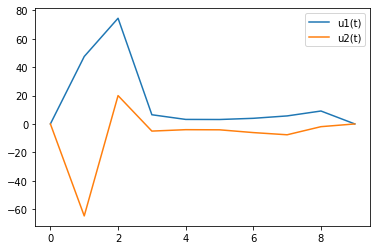

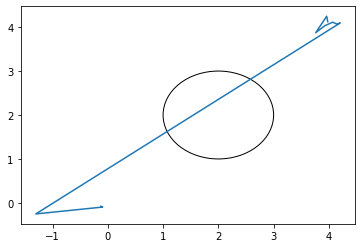

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 5.85e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.06e+03  4.67e+02  1.00e+00 -3.58e+05  6.86e+04  9.90e-11  7.99e-03 
   100| 3.21e-01  1.18e+01  1.45e-02 -5.58e+01 -5.42e+01  3.81e-12  1.29e-02 
   200| 5.52e-01  7.12e+00  9.98e-01 -9.60e+01  3.85e+02  6.13e-

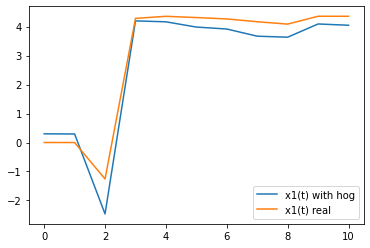

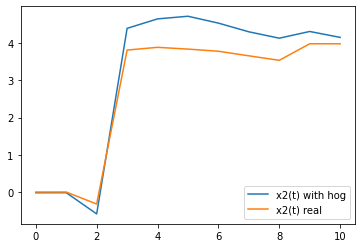

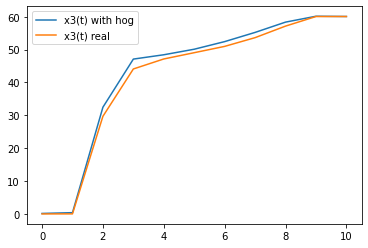

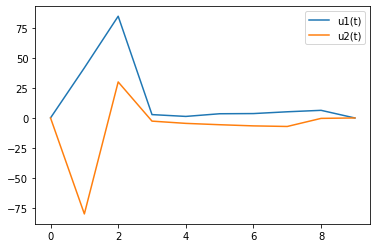

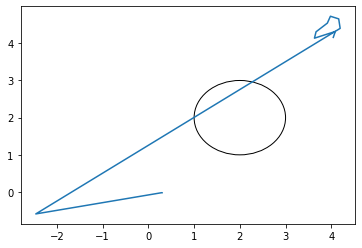

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 1.02e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.93e+03  4.26e+02  1.00e+00 -3.40e+05  6.18e+04  9.38e-11  8.21e-03 
   100| 1.27e-01  5.22e+00  9.95e-01  2.23e+01 -1.69e+02  4.24e-12  1.32e-02 
   200| 4.14e-01  8.89e+00  3.08e-01  7.27e+01  1.38e+02  2.38e-

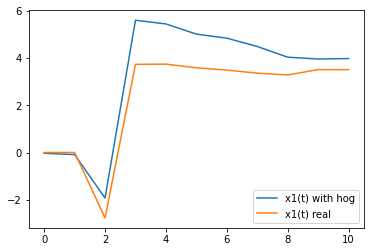

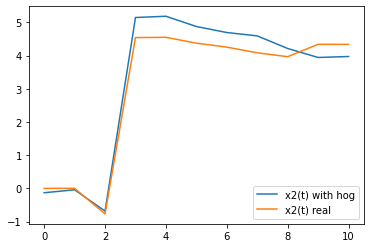

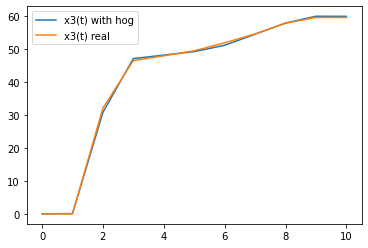

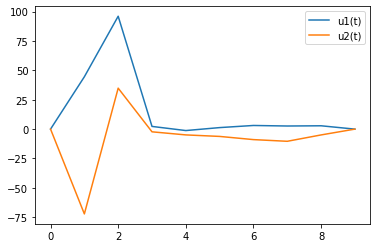

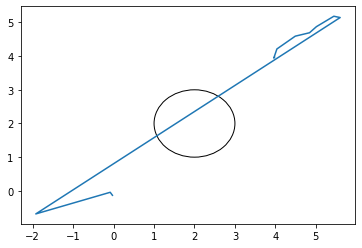

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 2.58e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.01e+03  4.64e+02  1.00e+00 -3.53e+05  6.59e+04  9.73e-11  8.58e-03 
   100| 2.22e-01  6.95e+00  9.94e-01  3.88e+01 -1.36e+02  6.67e-12  1.32e-02 
   200| 4.57e-02  6.07e+00  5.64e-01 -7.85e+00 -2.95e+01  1.55e-

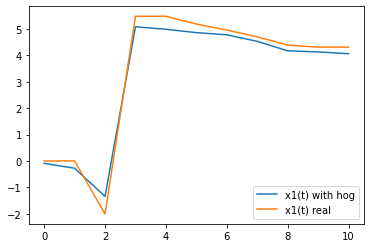

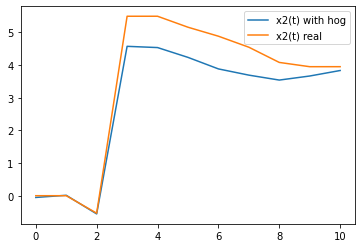

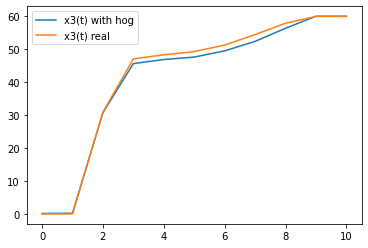

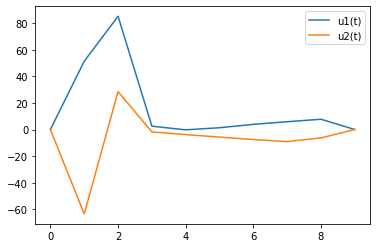

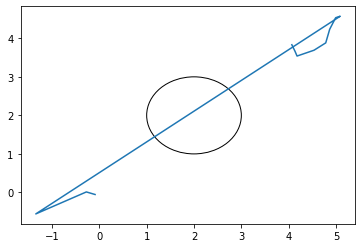

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.43e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.01e+03  4.58e+02  1.00e+00 -3.50e+05  6.72e+04  9.70e-11  8.33e-03 
   100| 1.87e-01  6.92e+00  6.42e-01  3.25e+01  1.51e+02  2.17e-12  1.30e-02 
   200| 7.28e-02  7.86e+00  9.98e-01  1.24e+01 -3.90e+02  8.82e-

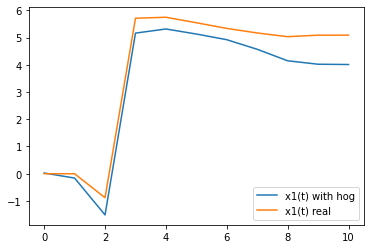

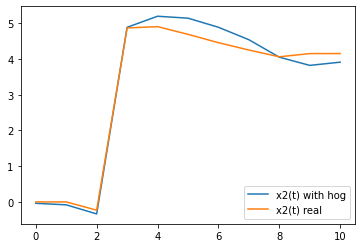

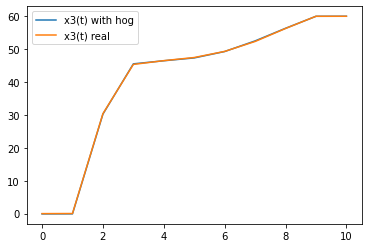

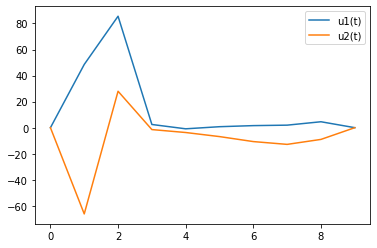

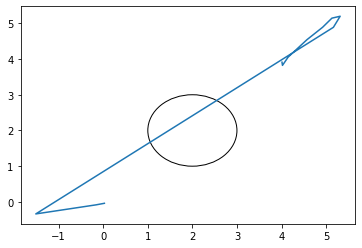

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.74e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.08e+03  4.91e+02  1.00e+00 -3.62e+05  7.05e+04  1.00e-10  1.16e-03 
   100| 4.48e-01  4.16e+00  9.91e-01 -7.78e+01  3.11e+01  3.99e-12  1.55e-02 
   200| 9.19e-02  8.28e+00  8.07e-01  1.57e+01  1.51e+02  3.03e-

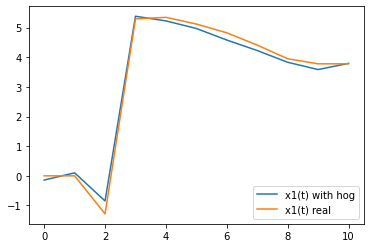

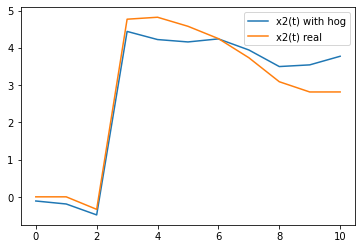

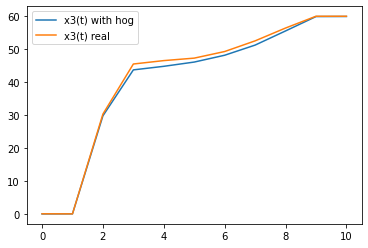

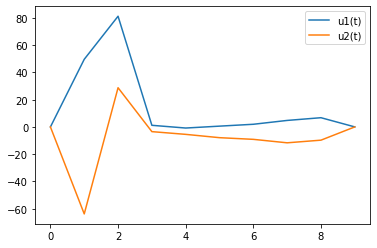

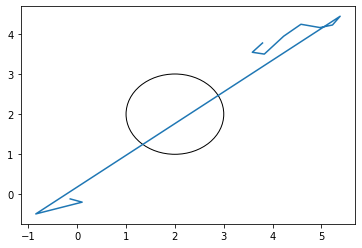

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.13e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.10e+03  4.87e+02  1.00e+00 -3.61e+05  7.22e+04  1.00e-10  6.98e-03 
   100| 3.90e-01  6.56e+00  4.23e-01  6.72e+01  1.66e+02  8.62e-12  1.24e-02 
   200| 1.22e-01  6.86e+00  9.94e-01  2.08e+01 -1.54e+02  6.83e-

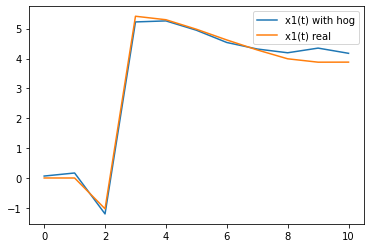

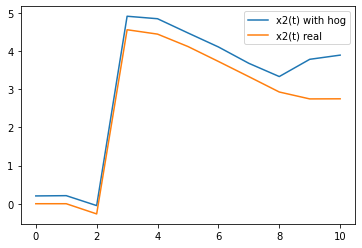

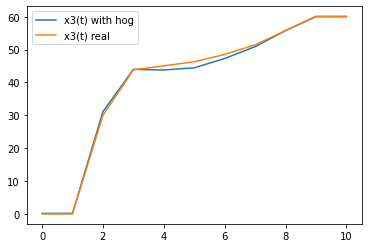

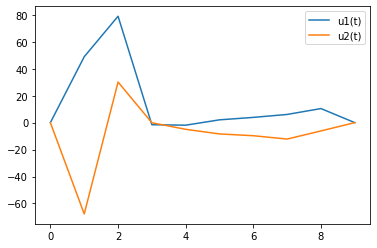

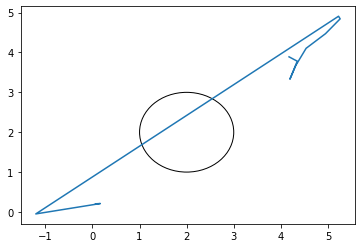

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 5.62e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.09e+03  4.89e+02  1.00e+00 -3.60e+05  7.23e+04  1.00e-10  8.10e-03 
   100| 3.28e-01  6.87e+00  8.89e-02  5.64e+01  6.75e+01  8.50e-12  1.28e-02 
   200| 4.52e-01  8.05e+00  2.99e-01  7.77e+01  4.17e+01  1.64e-

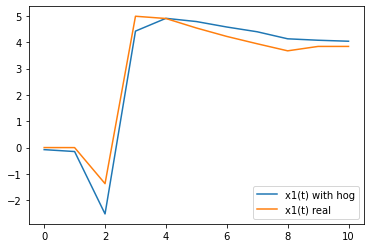

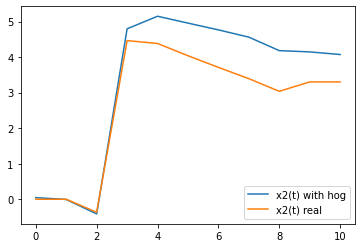

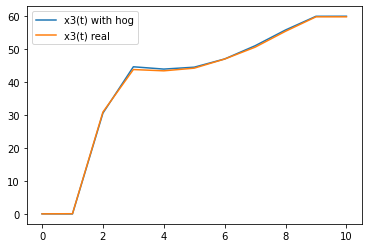

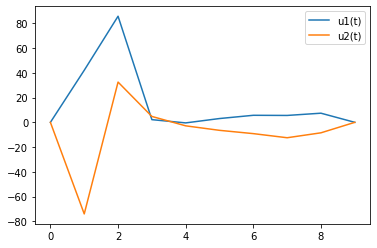

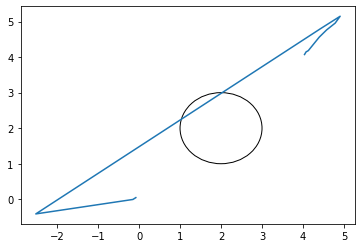

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 463
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 168, constraints m = 253
Cones:	primal zero / dual free vars: 35
	linear vars: 61
	soc vars: 157, soc blks: 42
Setup time: 8.12e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.14e+03  5.09e+02  1.00e+00 -3.68e+05  7.43e+04  1.02e-10  4.92e-03 
   100| 2.18e-01  8.27e+00  7.27e-01  3.76e+01  2.40e+02  3.89e-12  1.09e-02 
   200| 4.57e-01  1.87e+01  9.96e-01  7.86e+01 -1.66e+02  5.66e-

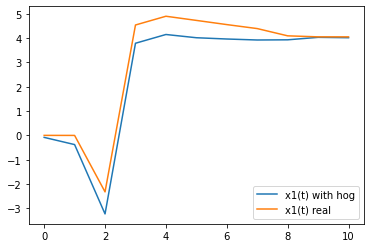

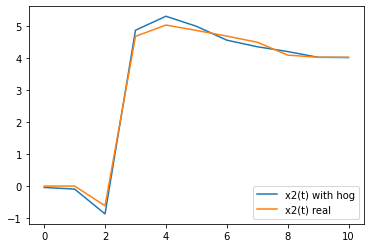

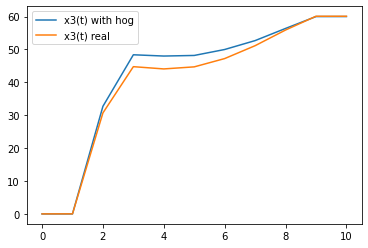

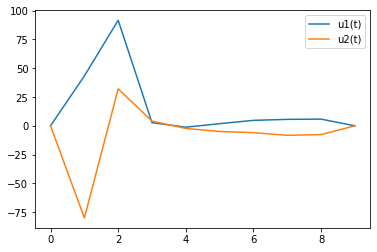

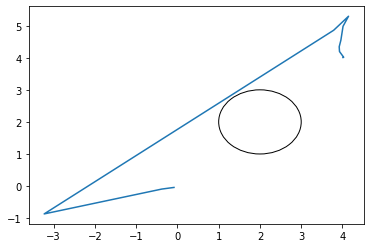

Real trajectory with calculated u signal


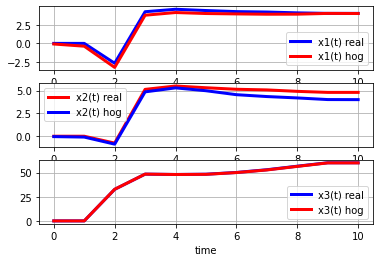

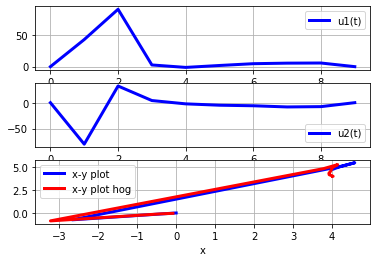

time passed to calculate the trajectory [seconds]:=
38.99075889587402
time disc:=
13.949927806854248
time cvx:=
9.960803270339966


In [ ]:
from sympy import symbols, IndexedBase, Idx
import sympy as sp
import numpy as np
import time 
from sympy import *
import matplotlib.patches as pat

#let's define the variables of the class (u inputs and x states)
u = IndexedBase('u')
n_in = symbols('n_in ', integer=True)
u[n_in]
#you can change the number of input but not the name
n_in = Idx('n_in', 2)
x = IndexedBase('x')
n_states = symbols('n_states', integer=True)
x[n_states]
#You can change the number of states not the name
n_states = Idx('n_states', 3)

# steady state conditions
x_init = [0,0,0]
u_ss = [1,1]
# final time
tf = 10 #(seconds)
#resolution
k = 1
# number of time points
n = tf * k + 1      #total points
# time points
dt = tf/n
t = np.linspace(0,tf,n)

#define the ode of the system
Z = [(.16/2)*(u[0]+u[1])*sp.cos((3.14/180)*x[2]),(.16/2)*(u[0]+u[1])*sp.sin((3.14/180)*x[2]),(.16/.55)*(u[0]-u[1])]
eq = DiscretizeandLinearizeGeneric(Z,np.zeros(x[n_states].shape[0]),np.ones(u[n_in].shape[0]),n)

# define inputs over time 
u1= np.ones(n) * u_ss[0]
u2= np.ones(n) * u_ss[1]
uw = np.array( [u1,u2])
#define the goal  position and the condition initial of the velocity
x_fin = [4,4,60]
u_in = [0,0]
#set the start time 
start = time.time()
# Some times to record each part
time_disc = 0
time_cvx = 0
x_len = len(x_init)
uante = [[None] * x_len * n]
xante = [[None] * x_len * n]
traj_fin = [[None]*x_len ]
p = np.array([2,2]) 
#iteration to find the optimum result
for i in range (20):
  st = time.time ()
  #resolution discrete sistem
  x1,x2,x3 = eq.disc(uw,n,dt,x_init)
  Ad_list,Bd_list,Cd_list = eq.get_list()
  time_disc += (time.time () - st) 
  #call the Convex optimization class to resolve the problem 
  st = time.time ()
  cvx = ConvexOpt(n,x_init,x_fin,u_in,Ad_list,Bd_list,Cd_list,xante,uante,p)
  #tell to optimize the power 
  opt_pow = True
  #tell to optimize the rapidity of convergence
  opt_conv = True
  xout,uout = cvx.CVXOPT(opt_pow,opt_conv)
  uw = uout
  time_cvx += (time.time () - st) 
  uante = np.copy(uout)
  xante = np.copy(xout)
  #plot the results 
  print("Results of the convexification number :",i+1)
  plt.plot(xout[0],label='x1(t) with hog')
  plt.plot(x1,label='x1(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(xout[1],label='x2(t) with hog')
  plt.plot(x2,label='x2(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(xout[2],label='x3(t) with hog')
  plt.plot(x3,label='x3(t) real')
  plt.legend(loc='best')
  plt.show()
  plt.plot(uw[0],label='u1(t)')
  plt.plot(uw[1],label='u2(t)')
  plt.legend(loc='best')
  plt.show()
  #obstacle affiche 
  c = pat.Circle((2,2), 1, fill = False)
  plt.gcf().gca().add_artist(c) 
  plt.plot(xout[0], xout[1], label="traj")
  plt.show()
  traj_fin = xout

done = time.time()
#plot the true trajectory calculated take into account the estimated u vector with cvx optimization
x1,x2,x3 = eq.disc(uw,n,dt,x_init)
print("Real trajectory with calculated u signal")
plt.figure(1)
plt.subplot(3,1,1)
plt.plot(t,x1,'b-',linewidth=3,label='x1(t) real')
plt.plot(t,traj_fin[0],'r-',linewidth=3,label='x1(t) hog')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(t,x2,'r-',linewidth=3,label='x2(t) real')
plt.plot(t,traj_fin[1],'b-',linewidth=3,label='x2(t) hog')
plt.xlabel('time')
plt.legend(loc='best')
plt.grid()
plt.subplot(3,1,3)
plt.plot(t,x3,'b-',linewidth=3,label='x3(t) real')
plt.plot(t,traj_fin[2],'r-',linewidth=3,label='x3(t) hog')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.show()

plt.subplot(3,1,1)
plt.plot(uw[0],'b-',linewidth=3,label='u1(t)')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(uw[1],'b-',linewidth=3,label='u2(t)')
plt.xlabel('time')
plt.grid()
plt.legend(loc='best')
plt.subplot(3,1,3)
plt.plot(x1,x2,'b-',linewidth=3,label='x-y plot')
plt.plot(traj_fin[0],traj_fin[1],'r-',linewidth=3,label='x-y plot hog')
plt.xlabel('x')
plt.grid()
plt.legend(loc='best')
plt.show()
print("time passed to calculate the trajectory [seconds]:=")
elapsed = done - start
print(elapsed)
print("time disc:=")
print(time_disc)
print("time cvx:=")
print(time_cvx)